In [ ]:
!pip install spacy transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.8 MB/s eta 0:00:00


In [ ]:
! pip install -U accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 2.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import os
import pandas as pd
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset

import torch.optim as optim

import torchvision.transforms as transforms

from transformers import VisionEncoderDecoderModel, AutoFeatureExtractor, AutoTokenizer, Seq2SeqTrainer, Seq2SeqTrainingArguments, default_data_collator
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from datasets import load_from_disk

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
os.listdir('drive/MyDrive/Image_Caption')

['image-caption-model-secondary1.pth',
 '20000Dataset',
 'temp_dataset.csv',
 'image-caption-best_model.pth',
 'image-caption-model1.pth',
 'Copy_of_Final_Pretrained_Image_Caption.ipynb']

In [ ]:
# # Unzip
# !unzip 'drive/MyDrive/Unzipped Datasets/20000Dataset-20231010T184158Z-001.zip' -d '/content/drive/MyDrive/Image_Caption'

In [ ]:
os.listdir('drive/MyDrive/Image_Caption/20000Dataset/')

['train.csv',
 'test.csv',
 'valid.csv',
 'medical_cui_mapping.csv',
 'medical_cui_mapping.xlsx',
 '20k.xlsx',
 '20k.csv',
 'images']

In [ ]:
IMG_DIR = 'drive/MyDrive/Image_Caption/20000Dataset/images'
CSV_DIR = 'drive/MyDrive/Image_Caption/20000Dataset/20k.csv'
CAP_DIR = 'drive/MyDrive/Image_Caption/20000Dataset/medical_cui_mapping.csv'

# Hugging Face Dataset

In [ ]:
os.listdir('drive/MyDrive/Image Caption/hf_dataset')

['cache-55b7f6580358fb20.arrow',
 'cache-5ec16e6e2801405a.arrow',
 'data-00001-of-00004.arrow',
 'data-00003-of-00004.arrow',
 'data-00002-of-00004.arrow',
 'data-00000-of-00004.arrow',
 'cache-d761210f28ed78bc.arrow',
 'cache-0c5d7ad8cebcc7dc.arrow',
 'data-00000-of-00001.arrow',
 'dataset_info.json',
 'state.json',
 'cache-313558ebd46f2cd3.arrow',
 'cache-9d9b1dfd66e26cb8.arrow',
 'cache-995300235721145a.arrow',
 'cache-00955e7508a5a6d0.arrow']

In [ ]:
ds_lg = load_from_disk('drive/MyDrive/Image Caption/hf_dataset')

In [ ]:
ds = ds_lg.select(range(100))

In [ ]:
ds_test = ds_lg.select(range(100, 110))

In [ ]:
print(ds_test)

Dataset({
    features: ['Images', 'Captions'],
    num_rows: 10
})


In [ ]:
ds_test = ds_test.rename_column('Images', 'image_path')
ds_test = ds_test.rename_column('Captions','caption')

In [ ]:
# ds_test = ds_test.remove_columns('caption')

In [ ]:
print(ds_test)

Dataset({
    features: ['image_path', 'caption'],
    num_rows: 10
})


In [ ]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image_path', 'caption'],
        num_rows: 90
    })
    test: Dataset({
        features: ['image_path', 'caption'],
        num_rows: 10
    })
})


In [ ]:
ds = ds.rename_column('Images', 'image_path')
ds = ds.rename_column('Captions','caption')

In [ ]:
# ds = ds.remove_columns('__index_level_0__')

In [ ]:
ds = ds.train_test_split(test_size = 0.1, seed = 42)

In [ ]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image_path', 'caption'],
        num_rows: 90
    })
    test: Dataset({
        features: ['image_path', 'caption'],
        num_rows: 10
    })
})


In [ ]:
ds['pred'] = ds_test

In [ ]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image_path', 'caption'],
        num_rows: 90
    })
    test: Dataset({
        features: ['image_path', 'caption'],
        num_rows: 10
    })
    pred: Dataset({
        features: ['image_path', 'caption'],
        num_rows: 10
    })
})


In [ ]:
encoder = 'google/vit-base-patch16-224-in21k'
decoder = 'roberta-base'

In [ ]:
feature_extractor = AutoFeatureExtractor.from_pretrained(encoder)
tokenizer = AutoTokenizer.from_pretrained(decoder)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(encoder, decoder)

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForCausalLM were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.encoder.layer.2.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.5.crossattention.self.key.bias', 'roberta.encoder.layer.3.crossattention.self.value.bias', 'roberta.encoder.layer.3.crossattention.self.key.bias', 'roberta.encoder.layer.2.crossattention.self.key.bias', 'roberta.encoder.layer.7.crossattention.self.value.bias', 'roberta.encoder.layer.6.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.11.crossattention.self.value.bias', 'roberta.encoder.layer.9.crossattention.self.query.bias', 'roberta.encoder.layer.8.crossattention.output.dense.weight', 'roberta.encoder.layer.3.crossattention.output.LayerNorm.weight', 'roberta.encoder.layer.1.crossattention.self.query.weight', 'roberta.encoder.layer.2.crossattention.output.LayerNorm.weight', 'roberta.encoder.layer.11.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.5.c

In [ ]:
tokenizer.pad_token = tokenizer.eos_token
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

In [ ]:
ignore_pad_token_for_loss = True

In [ ]:
class ImageCaptionDataset(Dataset):
    def __init__(self, ds, ds_type, max_target_length):
        self.ds = ds
        self.max_target_length = max_target_length
        self.ds_type = ds_type
        self.img_dir = IMG_DIR

    def __getitem__(self, idx):
        image_path = self.ds[self.ds_type]['image_path'][idx]
        caption = self.ds[self.ds_type]['caption'][idx]
        model_inputs = dict()
        model_inputs['labels'] = self.tokenization_fn(caption, self.max_target_length)
        model_inputs['pixel_values'] = self.feature_extraction_fn(image_path)
        return model_inputs

    def __len__(self):
        return len(self.ds[self.ds_type])

    # text preprocessing step
    def tokenization_fn(self, caption, max_target_length):
        labels = tokenizer(caption,
                          padding="max_length",
                          max_length=max_target_length,
                          truncation=True).input_ids

        return labels

    # image preprocessing step
    def feature_extraction_fn(self, image_path):
        image = Image.open(os.path.join(self.img_dir, image_path))
        if image.mode != "RGB":
            image = image.convert("RGB")

        encoder_inputs = feature_extractor(images=image, return_tensors="np")

        return encoder_inputs.pixel_values[0]

In [ ]:
train_ds = ImageCaptionDataset(ds, 'train', 256)
eval_ds = ImageCaptionDataset(ds, 'test', 256)

In [ ]:
test_ds = ImageCaptionDataset(ds, 'pred', 256)

In [ ]:
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    output_dir="drive/MyDrive/Image Caption/image-captioning-output",
)

In [ ]:
trainer = Seq2SeqTrainer(
    model = model,
    tokenizer = feature_extractor,
    args = training_args,
    train_dataset = train_ds,
    eval_dataset = eval_ds,
    data_collator = default_data_collator
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.191880
2,No log,0.174687
3,No log,0.175843


TrainOutput(global_step=135, training_loss=0.1660776632803458, metrics={'train_runtime': 50.2138, 'train_samples_per_second': 5.377, 'train_steps_per_second': 2.689, 'total_flos': 4.888190157871104e+16, 'train_loss': 0.1660776632803458, 'epoch': 3.0})

In [ ]:
trainer.save_model("drive/MyDrive/Image_Caption/image-captioning-output")

In [ ]:
save_path = ('drive/MyDrive/Image_Caption/model.pth')

In [ ]:
torch.save(model.state_dict(), save_path)

In [ ]:
pred = trainer.predict(test_ds)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [ ]:
preds  = pred.predictions
labels = pred.label_ids

In [ ]:
decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

In [ ]:
print(decoded_labels)

['Needle device', 'Structure of popliteal artery', 'Diagnostic Imaging', 'Ultrasonography', 'Syrinx formation', 'Endometrium', 'Cannula device', 'Structure of temporalis muscle', 'Diffuse alveolar hemorrhage', 'Left atrial structure']


# Data Prep

In [ ]:
def dataFrame(img_dir, csv_dir, cap_dir):
  with open(csv_dir, 'r', newline='') as csv_file:
    # Create a CSV reader
    imgs = []
    caps_id = []
    csv_reader = csv.reader(csv_file)
    for row in csv_reader:
      img = row[0]
      if img == 'filename':
        continue
      captions = row[1]
      cap_list = captions.split(';')
      for cap in cap_list:
        imgs.append(img)
        caps_id.append(cap)
  with open(cap_dir, 'r', newline='') as cap_file:
    reader = csv.reader(cap_file)
    capt = {}
    for rows in reader:
      strings = ""
      for cols in rows:
        if rows.index(cols) == 0:
          keys = cols.split('\t')
          id = keys[0]
          strings += keys[1]
        else:
         strings = strings + ', ' + cols
      capt[id] = strings
  caps = []
  for idx in caps_id:
    caps.append(capt[idx])

  indexes = []
  for i in range(len(imgs)):
    path = os.path.join(img_dir, imgs[i])
    if os.path.exists(path):
      pass
    else:
      indexes.append(i)

  new_imgs = [imgs[i] for i in range(len(imgs)) if i not in indexes]
  new_caps_id = [caps_id[i] for i in range(len(caps_id)) if i not in indexes]
  new_caps = [caps[i] for i in range(len(caps)) if i not in indexes]
  # Create Dataframe
  dataframe = pd.DataFrame( {'Images': new_imgs, 'CaptionsId': new_caps_id, 'Captions': new_caps})
  dict = {}
  for idx, row in dataframe.iterrows():
    dict[row[0]] = row[2]
  images = dict.keys()
  df = pd.DataFrame({'Images':images})
  df['Captions'] = df['Images'].map(dict)
  train_data, extra_data = train_test_split(df, train_size = 0.2, random_state = 42)
  test_data, data = train_test_split(extra_data, train_size = 0.05, random_state = 42)

  return train_data, test_data

In [ ]:
data, test_data = dataFrame(IMG_DIR, CSV_DIR, CAP_DIR)

In [ ]:
print(len(data), len(test_data))

2619 523


In [ ]:
data.reset_index(drop = True, inplace = True)

In [ ]:
data.to_csv("drive/MyDrive/Image_Caption/temp_dataset.csv", index = False)

# Dataset and Dataloader

In [ ]:
data = pd.read_csv('drive/MyDrive/Image_Caption/temp_dataset.csv')

In [ ]:
data.reset_index(drop = True, inplace = True)

In [ ]:
# from datasets import Dataset

In [ ]:
# hf_data = Dataset.from_pandas(data)

In [ ]:
# print(hf_data)

Dataset({
    features: ['Images', 'Captions'],
    num_rows: 2619
})


In [ ]:
# hf_data.save_to_disk("drive/MyDrive/Image Caption/hf_dataset")

Saving the dataset (0/1 shards):   0%|          | 0/2619 [00:00<?, ? examples/s]

In [ ]:
train_data, valid_data = train_test_split(data, test_size = 0.1, random_state= 42)

In [ ]:
train_data.reset_index(drop = True, inplace = True)
valid_data.reset_index(drop = True, inplace = True)

In [ ]:
image_processor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
encoder = 'google/vit-base-patch16-224-in21k'
decoder = 'roberta-base'

In [ ]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(encoder, decoder)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForCausalLM were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.encoder.layer.8.crossattention.output.LayerNorm.weight', 'roberta.encoder.layer.2.crossattention.self.key.bias', 'roberta.encoder.layer.3.crossattention.output.dense.weight', 'roberta.encoder.layer.1.crossattention.self.key.bias', 'roberta.encoder.layer.1.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.8.crossattention.self.query.weight', 'roberta.encoder.layer.0.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.3.crossattention.output.LayerNorm.weight', 'roberta.encoder.layer.11.crossattention.self.value.weight', 'roberta.encoder.layer.10.crossattention.output.dense.bias', 'roberta.encoder.layer.5.crossattention.self.key.weight', 'roberta.encoder.layer.10.crossattention.self.key.bias', 'roberta.encoder.layer.5.crossattention.output.dense.bias', 'roberta.encoder.layer.0.crossattention.self.key.weight', 'roberta.encoder.layer.9.

In [ ]:
print(model)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
model = model.to(device)

In [ ]:
for param in model.encoder.parameters():
    param.requires_grad = False

In [ ]:
tokenizer.pad_token = tokenizer.eos_token
# model.config.eos_token_id = tokenizer.eos_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

In [ ]:
class ImageCaptionDataset(Dataset):
  def __init__(self, img_dir, dataset, tokenizer = tokenizer, max_caption_length = 20):
    self.dataset = dataset
    self.img_dir = img_dir
    self.imgs = self.dataset['Images']
    self.caps = self.dataset['Captions']
    self.tokenizer = tokenizer
    self.max_caption_length = max_caption_length

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    caption = self.caps[idx]
    img_id = self.imgs[idx]
    img = Image.open(os.path.join(self.img_dir, img_id)).convert("RGB")
    img = transforms.Resize((224,224))(img)
    pixel_values = image_processor(img, return_tensors="pt").pixel_values.squeeze(0)

    encoding = self.tokenizer(caption,
                       max_length = self.max_caption_length,
                       padding="max_length",
                       truncation=True,
                       return_tensors="pt")
    labels, attention_mask = encoding["input_ids"].squeeze(0), encoding["attention_mask"].squeeze(0)

    return pixel_values, labels, attention_mask

In [ ]:
# def get_max_len(df):
#   captions = df['Captions']
#   max_words_count = captions.str.split().apply(len).max()
#   return max_words_count

In [ ]:
# max_length = get_max_len(train_data)
# print(max_length)

In [ ]:
# max_length = get_max_len(valid_data)
# print(max_length)

In [ ]:
# max_length = get_max_len(test_data)
# print(max_length)

In [ ]:
def get_loader(
    img_dir,
    data,
    batch_size = 4,
    shuffle = True):

  dataset = ImageCaptionDataset(img_dir, data)

  dataloader = DataLoader(
      dataset = dataset,
      batch_size = batch_size,
      shuffle = shuffle,
  )
  return dataloader

In [ ]:
train_loader = get_loader(IMG_DIR, train_data)
valid_loader = get_loader(IMG_DIR, valid_data, shuffle = False)
# test_loader = get_loader(IMG_DIR, test_data, shuffle = False)

In [ ]:
import numpy as np

Intestines,  Small
Structure of axillary artery
Ultrasonography
Femoral vein


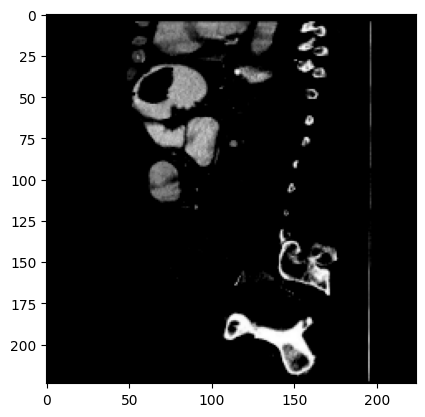

In [ ]:
for idx, sample in enumerate(train_loader):
  image = sample[0]
  caption = sample[1]
  for i, _ in enumerate(image):
    plt.imshow(np.transpose(image[i].numpy(), (1, 2, 0)))
  for j, _ in enumerate(caption):
    print(tokenizer.decode(caption[j], skip_special_tokens=True))
  break

In [ ]:
print(tokenizer.decode([  0, 41436,  4328, 12231, 10486,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2], skip_special_tokens= True))

Ultrasonography


In [ ]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
epochs = 20

In [ ]:
version = 1

In [ ]:
save_path = f"drive/MyDrive/Image_Caption/image-caption-model{version}.pth"

In [ ]:
best_model = f"drive/MyDrive/Image_Caption/image-caption-best_model.pth"

In [ ]:
# model.load_state_dict(torch.load(save_path))

In [ ]:
best_valid_loss = 0.0
for epoch in tqdm(range(epochs)):
    total_train_loss = 0.0
    total_valid_loss = 0.0

    model.train()
    for batch in tqdm(train_loader):
        # Process the batch data (images and captions)
        images_train = batch[0].squeeze().to(device)
        captions_train = batch[1].to(device)
        attention_mask_train = batch[2].to(device)

        optimizer.zero_grad()

        # Forward pass
        image_features = model.encoder(images_train)
        # print(image_features)
        output_logits = model.decoder(captions_train)

        # print(output_logits[0])

        # Calculate loss
        train_loss = criterion(output_logits[0].view(-1, output_logits[0].size(-1)), captions_train.view(-1))
        total_train_loss += train_loss.item()

        # Backpropagation
        train_loss.backward()
        optimizer.step()

    model.eval()
    for batch in tqdm(valid_loader):
        # Process the batch data (images and captions)
        images_valid = batch[0].squeeze().to(device)
        captions_valid = batch[1].to(device)
        attention_mask_valid = batch[2].to(device)

        # Forward pass
        image_features = model.encoder(images_valid)
        output_logits = model.decoder(image_features.last_hidden_state, captions_valid)

        # Calculate loss
        valid_loss = criterion(output_logits[0].view(-1, output_logits[0].size(-1)), captions_valid.view(-1))

        total_valid_loss += valid_loss.item()
    # Calculate average loss per epoch
    avg_train_loss = total_train_loss / len(train_loader)
    avg_valid_loss = total_valid_loss / len(valid_loader)
    if epoch == 0:
      best_valid_loss = avg_valid_loss
      torch.save(model.state_dict(), save_path)
    elif avg_valid_loss < best_valid_loss:
      best_valid_loss = avg_valid_loss
      torch.save(model.state_dict(), save_path)
    print(f"Epoch [{epoch + 1}/{epochs}] || Train Loss: {avg_train_loss:.4f} || Valid Loss: {avg_valid_loss: .4f}")

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/590 [00:00<?, ?it/s]

ValueError: not enough values to unpack (expected 4, got 3)

In [ ]:
# best_valid_loss = 0.0
# for epoch in tqdm(range(epochs)):
#     if (epoch+1) % 10 == 0:
#       torch.save(model.state_dict(), save_path)
#     total_train_loss = 0.0
#     total_valid_loss = 0.0

#     model.train()
#     for batch in tqdm(train_loader):
#         # Process the batch data (images and captions)
#         images_train = batch[0].to(device)
#         captions_train = batch[1].to(device)
#         att_mask_train = batch[2].to(device)

#         optimizer.zero_grad()

#         # Forward pass
#         outputs = model(
#             pixel_values = images_train,
#             decoder_input_ids = captions_train,
#             decoder_attention_mask = att_mask_train,
#             labels = captions_train
#         )

#         # print(outputs)

#         # Calculate loss
#         train_loss = outputs.loss
#         total_train_loss += train_loss.item()

#         # Backpropagation

#         train_loss.backward()
#         optimizer.step()

#     model.eval()
#     for batch in tqdm(valid_loader):
#         # Process the batch data (images and captions)
#         images_valid = batch[0].to(device)
#         captions_valid = batch[1].to(device)

#         # Forward pass
#         with torch.no_grad():
#           outputs = model(
#             pixel_values=images_valid,
#             labels = captions_valid,
#             return_dict=True
#         )

#         print(outputs)

#         # Calculate loss
#         valid_loss = outputs.loss
#         total_valid_loss += train_loss.item()
#         total_valid_loss += valid_loss.item()
#     # Calculate average loss per epoch
#     avg_train_loss = total_train_loss / len(train_loader)
#     avg_valid_loss = total_valid_loss / len(valid_loader)
#     if epoch == 0:
#       best_valid_loss = avg_valid_loss
#       torch.save(model.state_dict(), save_path)
#     elif avg_valid_loss < best_valid_loss:
#       best_valid_loss = avg_valid_loss
#       torch.save(model.state_dict(), best_model)
#     print(f"Epoch [{epoch + 1}/{epochs}] || Train Loss: {avg_train_loss:.4f} || Valid Loss: {avg_valid_loss: .4f}")


In [ ]:
# best_valid_loss = 0.0
# for epoch in tqdm(range(epochs)):
#     if (epoch+1) % 10 == 0:
#       torch.save(model.state_dict(), save_path)
#     total_train_loss = 0.0
#     total_valid_loss = 0.0

#     model.train()
#     for batch in tqdm(train_loader):
#         # Process the batch data (images and captions)
#         images_train = batch[0].to(device)
#         captions_train = batch[1].to(device)

#         # Forward pass
#         outputs = model(
#             pixel_values=images_train,
#             labels = captions_train,
#             return_dict=True
#         )

#         # print(outputs)

#         # Calculate loss
#         train_loss = outputs.loss
#         total_train_loss += train_loss.item()

#         # Backpropagation
#         optimizer.zero_grad()
#         train_loss.backward()
#         optimizer.step()

#     model.eval()
#     for batch in tqdm(valid_loader):
#         # Process the batch data (images and captions)
#         images_valid = batch[0].to(device)
#         captions_valid = batch[1].to(device)

#         # Forward pass
#         outputs = model(
#             pixel_values=images_valid,
#             labels = captions_valid,
#             return_dict=True
#         )

#         # Calculate loss
#         valid_loss = outputs.loss
#         total_valid_loss += valid_loss.item()
#     # Calculate average loss per epoch
#     avg_train_loss = total_train_loss / len(train_loader)
#     avg_valid_loss = total_valid_loss / len(valid_loader)
#     if epoch == 0:
#       best_valid_loss = avg_valid_loss
#       torch.save(model.state_dict(), save_path)
#     elif avg_valid_loss < best_valid_loss:
#       best_valid_loss = avg_valid_loss
#       torch.save(model.state_dict(), best_model)
#     print(f"Epoch [{epoch + 1}/{epochs}] || Train Loss: {avg_train_loss:.4f} || Valid Loss: {avg_valid_loss: .4f}")

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

Epoch [1/20] || Train Loss: 1.7292 || Valid Loss:  7.5124


  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

Epoch [2/20] || Train Loss: 1.6683 || Valid Loss:  8.5266


  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

Epoch [3/20] || Train Loss: 1.6440 || Valid Loss:  8.4200


  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

Epoch [4/20] || Train Loss: 1.6384 || Valid Loss:  5.3718


  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

Epoch [5/20] || Train Loss: 1.6368 || Valid Loss:  7.3467


  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

Epoch [6/20] || Train Loss: 1.6219 || Valid Loss:  8.1339


  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

Epoch [7/20] || Train Loss: 1.6282 || Valid Loss:  8.1422


  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

Epoch [8/20] || Train Loss: 1.6183 || Valid Loss:  7.8040


  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

Epoch [9/20] || Train Loss: 1.6127 || Valid Loss:  6.3631


  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

Epoch [10/20] || Train Loss: 1.6079 || Valid Loss:  7.6771


  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

Epoch [11/20] || Train Loss: 1.5932 || Valid Loss:  6.7141


  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

Epoch [12/20] || Train Loss: 1.5952 || Valid Loss:  8.0130


  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

Epoch [13/20] || Train Loss: 1.5989 || Valid Loss:  9.6504


  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

Epoch [14/20] || Train Loss: 1.5880 || Valid Loss:  8.4350


  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

Epoch [15/20] || Train Loss: 1.5882 || Valid Loss:  7.9768


  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

Epoch [16/20] || Train Loss: 1.5799 || Valid Loss:  9.4526


  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

Epoch [17/20] || Train Loss: 1.5815 || Valid Loss:  9.9574


  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

Epoch [18/20] || Train Loss: 1.5686 || Valid Loss:  7.8027


  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

Epoch [19/20] || Train Loss: 1.5747 || Valid Loss:  8.8641


  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

Epoch [20/20] || Train Loss: 1.5669 || Valid Loss:  8.9923


# Extra

In [ ]:
save_path = f"drive/MyDrive/Image_Caption/image-caption-model-secondary{version}.pth"

In [ ]:
best_model = f"drive/MyDrive/Image_Caption/image-caption-best_model-secondary.pth"

In [ ]:
version = 1

In [ ]:
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [ ]:
best_valid_loss = 0.0
for epoch in tqdm(range(epochs)):
    total_train_loss = 0.0
    total_valid_loss = 0.0

    model.train()
    for batch in tqdm(train_loader):
        # Process the batch data (images and captions)
        images_train = batch[0].to(device)
        captions_train = batch[1].to(device)
        att_mask_train = batch[2].to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(
            pixel_values = images_train,
            decoder_input_ids = captions_train,
            decoder_attention_mask = att_mask_train,
            labels = captions_train
        )

        # print(outputs)

        # Calculate loss
        train_loss = outputs.loss
        total_train_loss += train_loss.item()

        # Backpropagation

        train_loss.backward()
        optimizer.step()

    model.eval()
    for batch in tqdm(valid_loader):
        # Process the batch data (images and captions)
        images_valid = batch[0].to(device)
        captions_valid = batch[1].to(device)

        # Forward pass
        with torch.no_grad():
          outputs = model(
            pixel_values=images_valid,
            labels = captions_valid,
            return_dict=True
        )

        # print(outputs)

        # Calculate loss
        valid_loss = outputs.loss
        total_valid_loss += train_loss.item()
        total_valid_loss += valid_loss.item()
    # Calculate average loss per epoch
    avg_train_loss = total_train_loss / len(train_loader)
    avg_valid_loss = total_valid_loss / len(valid_loader)
    if epoch == 0:
      best_valid_loss = avg_valid_loss
      torch.save(model.state_dict(), save_path)
    elif avg_valid_loss < best_valid_loss:
      best_valid_loss = avg_valid_loss
      torch.save(model.state_dict(), best_model)
    print(f"Epoch [{epoch + 1}/{epochs}] || Train Loss: {avg_train_loss:.4f} || Valid Loss: {avg_valid_loss: .4f}")
torch.save(model.state_dict(), save_path)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

Epoch [1/10] || Train Loss: 1.7979 || Valid Loss:  8.1847


  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

Epoch [2/10] || Train Loss: 1.7995 || Valid Loss:  8.4947


  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

Epoch [3/10] || Train Loss: 1.7936 || Valid Loss:  8.0189


  0%|          | 0/590 [00:00<?, ?it/s]

In [ ]:
version = 2

In [ ]:
save_path = f"drive/MyDrive/Image Caption/image-caption-model-{version}.pth"

In [ ]:
best_model = f"drive/MyDrive/Image Caption/image-caption-best_model.pth"

In [ ]:
best_valid_loss = 7.2206
for epoch in tqdm(range(epochs)):
    total_train_loss = 0.0
    total_valid_loss = 0.0

    model.train()
    for batch in tqdm(train_loader):
        # Process the batch data (images and captions)
        images_train = batch[0].to(device)
        captions_train = batch[1].to(device)

        # Forward pass
        outputs = model(
            pixel_values=images_train,
            labels = captions_train,
            return_dict=True
        )

        # print(outputs)

        # Calculate loss
        train_loss = outputs.loss
        total_train_loss += train_loss.item()

        # Backpropagation
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

    model.eval()
    for batch in tqdm(valid_loader):
        # Process the batch data (images and captions)
        images_valid = batch[0].to(device)
        captions_valid = batch[1].to(device)

        # Forward pass
        outputs = model(
            pixel_values=images_valid,
            labels = captions_valid,
            return_dict=True
        )

        # Calculate loss
        valid_loss = outputs.loss
        total_valid_loss += valid_loss.item()
    # Calculate average loss per epoch
    avg_train_loss = total_train_loss / len(train_loader)
    avg_valid_loss = total_valid_loss / len(valid_loader)
    if epoch == 0:
      best_valid_loss = avg_valid_loss
      torch.save(model.state_dict(), save_path)
    elif avg_valid_loss < best_valid_loss:
      best_valid_loss = avg_valid_loss
      torch.save(model.state_dict(), best_model)
    print(f"Epoch [{epoch + 1}/{epochs}] || Train Loss: {avg_train_loss:.4f} || Valid Loss: {avg_valid_loss: .4f}")
torch.save(model.state_dict(), save_path)

In [ ]:
 # my_model = model.load_state_dict(torch.load(save_path, map_location=torch.device('cpu')))

# Inference

In [ ]:
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [ ]:
# print(model)

In [ ]:
def convert(img_id, img_dir):
    img = Image.open(os.path.join(img_dir, img_id)).convert("RGB")
    img = transforms.Resize((224,224))(img)

    return img

In [ ]:
data = pd.read_csv('drive/MyDrive/Image_Caption/temp_dataset.csv')

In [ ]:
data.head(20)

,Images,Captions
0,ImageCLEFmedical_Caption_2023_train_016550.jpg,Cerebral cortex
1,ImageCLEFmedical_Caption_2023_train_015977.jpg,Hematoma
2,ImageCLEFmedical_Caption_2023_train_013507.jpg,Calcified nodule
3,ImageCLEFmedical_Caption_2023_train_030202.jpg,Echocardiography
4,ImageCLEFmedical_Caption_2023_train_001070.jpg,CT coronal
5,ImageCLEFmedical_Caption_2023_train_032525.jpg,Spleen
6,ImageCLEFmedical_Caption_2023_train_039965.jpg,Arteries
7,ImageCLEFmedical_Caption_2023_train_000432.jpg,X-Ray Computed Tomography
8,ImageCLEFmedical_Caption_2023_train_005072.jpg,Plain x-ray
9,ImageCLEFmedical_Caption_2023_train_035502.jpg,angiogram


In [ ]:
test_img = 'ImageCLEFmedical_Caption_2023_train_035727.jpg'

In [ ]:
image = convert(test_img, IMG_DIR)

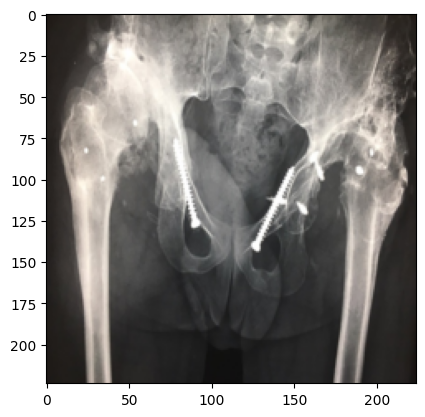

In [ ]:
plt.imshow(image)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
pixel_values = feature_extractor(image, return_tensors="pt").pixel_values
pixel_values = pixel_values.to(device)
print(pixel_values.shape)
generated = model.generate(pixel_values, do_sample=False, max_length=256)
print(generated)
result = tokenizer.decode(generated[0], skip_special_tokens = True)


print(result)

torch.Size([1, 3, 224, 224])
tensor([[0, 0, 2]], device='cuda:0')



In [ ]:
en = tokenizer('Chest')

In [ ]:
print(en)

{'input_ids': [0, 48351, 2], 'attention_mask': [1, 1, 1]}


In [ ]:
print(tokenizer.cls_token_id)

101
